In [1]:
import pandas as pd
import sys
import os
sys.path.insert(0, '../../../')

from notebooks.utils import _ALEXA_DATA_PATH, load_node_features, load_level_data, create_nodes, export_model_as_feature
from train import run_experiment

2022-01-12 01:44:42.971734: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load audience overlap edges for level 1

In [2]:
audience_overlap_sites = load_level_data(os.path.join(_ALEXA_DATA_PATH, 'corpus_2020_audience_overlap_sites_scrapping_result.json'), level=1)
audience_overlap_sites_NODES = create_nodes(audience_overlap_sites)

print(audience_overlap_sites_NODES[:5])

01-12 01:44:44 notebooks.utils INFO     Loaded 3489 nodes with records level <= 1 and child size:16981


[('crooked.com', 'votesaveamerica.com'), ('crooked.com', 'art19.com'), ('crooked.com', 'promocodeportal.com'), ('crooked.com', 'mediamatters.org'), ('crooked.com', 'actblue.com')]


In [3]:
edge_df = pd.DataFrame(audience_overlap_sites_NODES, columns=['source', 'target'])

edge_df.head()

,source,target
0,crooked.com,votesaveamerica.com
1,crooked.com,art19.com
2,crooked.com,promocodeportal.com
3,crooked.com,mediamatters.org
4,crooked.com,actblue.com


### Find all unique nodes in edges

In [4]:
nodes_in_edges = list(set(edge_df.source.unique().tolist() + edge_df.target.unique().tolist()))
print('Number of unique nodes in edges:', len(nodes_in_edges), 'Sample:', nodes_in_edges[:5])

Number of unique nodes in edges: 10161 Sample: ['dailywire.com', 'ips-dc.org', 'tourismkelowna.com', 'viralpatriot.com', 'nerdist.com']


### 1. Load all node features

In [5]:
node_features_df = load_node_features()
node_features_df = node_features_df.set_index('site')
node_features_df.head()

,alexa_rank,daily_pageviews_per_visitor,daily_time_on_site,total_sites_linking_in,bounce_rate
site,,,,,
whistleblowersandrelators.com,NaN,NaN,NaN,NaN,NaN
geokov.com,2238341.0,1.0,NaN,60.0,0.900
trainingandfacilitation.ca,NaN,NaN,NaN,NaN,NaN
plumsolutions.com.au,1023533.0,1.0,138.0,60.0,0.813
dbdailyupdate.com,145283.0,1.7,179.0,64.0,0.756


# Subset node_features

In [6]:
node_features_df = node_features_df.loc[nodes_in_edges]

In [7]:
node_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10161 entries, dailywire.com to austin360.com
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   alexa_rank                   7465 non-null   float64
 1   daily_pageviews_per_visitor  7466 non-null   float64
 2   daily_time_on_site           5566 non-null   float64
 3   total_sites_linking_in       9861 non-null   float64
 4   bounce_rate                  5179 non-null   float64
dtypes: float64(5)
memory usage: 476.3+ KB


### 2. Fill all missing alexa_rank and total_sites_linking_in with 0 

In [8]:
node_features_df.alexa_rank = node_features_df.alexa_rank.fillna(0)
node_features_df.total_sites_linking_in = node_features_df.total_sites_linking_in.fillna(0)
node_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10161 entries, dailywire.com to austin360.com
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   alexa_rank                   10161 non-null  float64
 1   daily_pageviews_per_visitor  7466 non-null   float64
 2   daily_time_on_site           5566 non-null   float64
 3   total_sites_linking_in       10161 non-null  float64
 4   bounce_rate                  5179 non-null   float64
dtypes: float64(5)
memory usage: 476.3+ KB


### 3. Normalizing features

In [9]:
import math

node_features_df['normalized_alexa_rank'] = node_features_df['alexa_rank'].apply(lambda x: 1/x if x else 0)
node_features_df['normalized_total_sites_linked_in'] = node_features_df['total_sites_linking_in'].apply(lambda x: math.log2(x) if x else 0)

# Create Graph

In [10]:
import stellargraph as sg

G = sg.StellarGraph(node_features_df[['normalized_alexa_rank', 'normalized_total_sites_linked_in']], edge_df)

print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 10161, Edges: 17010

 Node types:
  default: [10161]
    Features: float32 vector, length 2
    Edge types: default-default->default

 Edge types:
    default-default->default: [17010]
        Weights: all 1 (default)
        Features: none


# Unsupervised Deep Graph Infomax

In [11]:
from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator
)
from stellargraph.layer import GCN, DeepGraphInfomax

from tensorflow.keras import Model
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 1. Specify the other optional parameter values: root nodes, the number of walks to take per node, the length of each walk, and random seed.

nodes = list(G.nodes())
number_of_walks = 1
length = 5

# 2. Create the UnsupervisedSampler instance with the relevant parameters passed to it.

fullbatch_generator = FullBatchNodeGenerator(G, sparse=False)
gcn_model = GCN(layer_sizes=[128], activations=["relu"], generator=fullbatch_generator)

corrupted_generator = CorruptedGenerator(fullbatch_generator)
gen = corrupted_generator.flow(G.nodes())

# 3. Create a node pair generator:

infomax = DeepGraphInfomax(gcn_model, corrupted_generator)
x_in, x_out = infomax.in_out_tensors()

deep_graph_infomax_model = Model(inputs=x_in, outputs=x_out)
deep_graph_infomax_model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))


Using GCN (local pooling) filters...


Sample: [0.0, 0.0, 0.0, 0.8009405732154846, 0.0, 0.55653977394104, 0.027066433802247047, 0.0, 0.0, 0.7395623922348022]


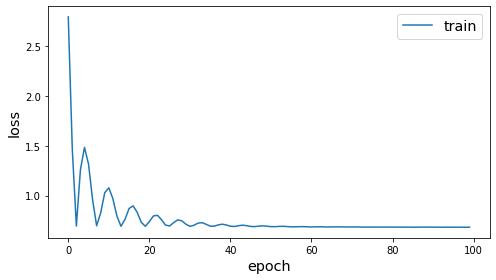

In [12]:
from stellargraph.utils import plot_history

epochs = 100

es = EarlyStopping(monitor="loss", min_delta=0, patience=20)
history = deep_graph_infomax_model.fit(gen, epochs=epochs, verbose=0, callbacks=[es])
plot_history(history)

x_emb_in, x_emb_out = gcn_model.in_out_tensors()

# for full batch models, squeeze out the batch dim (which is 1)
x_out = tf.squeeze(x_emb_out, axis=0)
emb_model = Model(inputs=x_emb_in, outputs=x_out)

node_features_fullbactch_generator = fullbatch_generator.flow(node_features_df.index)
node_embeddings = emb_model.predict(node_features_fullbactch_generator)

embeddings_wv = dict(zip(node_features_df.index.tolist(), node_embeddings.tolist()))

print('Sample:', embeddings_wv['crooked.com'][:10])

# Export embeddings as feature

In [13]:
export_model_as_feature(embeddings_wv, 'deep_graph_infomax_level_1')

'/Users/panayot/Documents/News-Media-Peers/data/acl2020/features/deep_graph_infomax_level_1.json'

In [14]:
run_experiment(features="deep_graph_infomax_level_1")

+------+---------------------+---------------+--------------------+----------------------------+
| task | classification_mode | type_training | normalize_features |          features          |
+------+---------------------+---------------+--------------------+----------------------------+
| fact |  single classifier  |    combine    |        True        | deep_graph_infomax_level_1 |
+------+---------------------+---------------+--------------------+----------------------------+


01-12 01:45:17 train        INFO     Start training...
01-12 01:45:17 train        INFO     Fold: 0
01-12 01:45:26 train        INFO     Fold: 1
01-12 01:45:31 train        INFO     Fold: 2
01-12 01:45:37 train        INFO     Fold: 3
01-12 01:45:41 train        INFO     Fold: 4


+------+---------------------+---------------+--------------------+----------------------------+--------------------+--------------------+--------------------+--------------------+
| task | classification_mode | type_training | normalize_features |          features          |      Macro-F1      |      Accuracy      |  Flip error-rate   |        MAE         |
+------+---------------------+---------------+--------------------+----------------------------+--------------------+--------------------+--------------------+--------------------+
| fact |  single classifier  |    combine    |        True        | deep_graph_infomax_level_1 | 42.940132831872106 | 56.344586728754365 | 12.456344586728754 | 0.5611175785797439 |
+------+---------------------+---------------+--------------------+----------------------------+--------------------+--------------------+--------------------+--------------------+
